# Quantile sketch bucket sizes for relative-error guarantees

From https://www.datadoghq.com/blog/engineering/computing-accurate-percentiles-with-ddsketch/#achieving-relative-error-guarantees:
> For this sketch to be efficient, we need to make sure its memory size, which only depends on the number of buckets, is low: we need to cover the full range of ingested values with as few buckets as possible. To accomplish this, we choose buckets that are as wide as possible: namely, whose relative width is twice the relative-error guarantee. At first glance, it seems that a huge number of buckets is required to cover practical ranges of values, but because the bucket width grows exponentially (the higher the bucket, the larger it can be), it’s not as bad as it first seems. For instance, to cover the range from 1 millisecond to 1 minute with a relative-error guarantee of 2 percent, we need 275 buckets, hence a sketch of about 2kB if 64-bit counters are used. Given the exponential nature of the bucket width, to cover the range from 1 nanosecond to 1 day, you would only need 3 times as many buckets: namely, 802 buckets.

This seems non-intuitive!

## code

In [25]:
import seaborn as sns

# the bucket values are actually the bucket boundaries

def fixed_buckets(start, stop, inc):
    xs = []
    cur = start
    while cur < stop:
        xs.append(cur)
        cur += inc
    return xs

def relative_buckets(start, stop, relerr):
    assert start >= 1
    assert (0 < relerr and relerr <= 1)
    # multiply by relerr factor 2x:
    # first to get to midpoint, then to get to end of bucket
    relerrmult = (1 + relerr) ** 2
    xs = []
    cur = start
    while cur <= stop:
        xs.append(cur)
        cur *= relerrmult
    return xs

In [26]:
bs = fixed_buckets(1, 10, 0.2)

46


<AxesSubplot:>

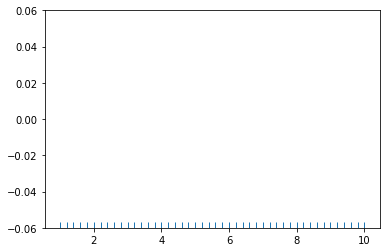

In [27]:
print(len(bs))
sns.rugplot(bs)

59


<AxesSubplot:>

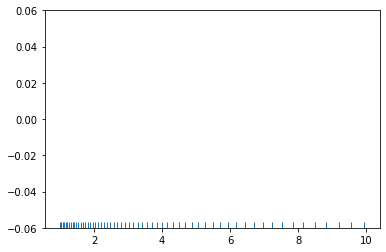

In [28]:
relbs = relative_buckets(1, 10, 0.02)
print(len(relbs))
sns.rugplot(relbs)

## testing assertion

> to cover the range from 1 millisecond to 1 minute with a relative-error guarantee of 2 percent, we need 275 buckets

> to cover the range from 1 nanosecond to 1 day, you would only need 3 times as many buckets: namely, 802 buckets.

In [34]:
def one_ms_to_1_minute():
    one_minute_in_ms = 1000 * 60
    bs = relative_buckets(1, one_minute_in_ms, 0.02)
    print(f'1ms to 1min: {len(bs)}')
    sns.rugplot(bs)
    return bs

def one_ns_to_1_day():
    one_day_in_ns = 1000 * 1000 * 1000 * 60 * 60 * 24
    bs = relative_buckets(1, one_day_in_ns, 0.02)
    print(f'1ns to 1day: {len(bs)}')
    sns.rugplot(bs)
    return bs


1ms to 1min: 278


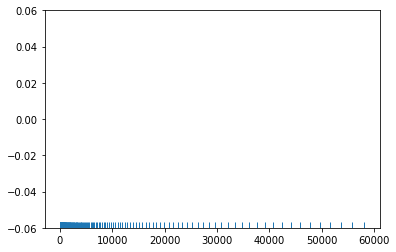

In [35]:
_ = one_ms_to_1_minute()

1ns to 1day: 811


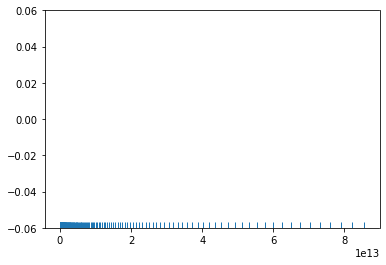

In [36]:
nsbs = one_ns_to_1_day()

In [37]:
nsbs[0:5]

[1, 1.0404, 1.08243216, 1.126162419264, 1.1716593810022657]

In [58]:
nsbs_tail_minutes = [t/1000/1000/1000/60 for t in nsbs[-5:]]
nsbs_tail_minutes

[1217.098227164511,
 1266.268995541957,
 1317.4262629618524,
 1370.6502839855114,
 1426.0245554585258]

In [61]:
# could be nearly an hour off at the tail
last_bucket_size = nsbs_tail_minutes[-1] - nsbs_tail_minutes[-2]
last_bucket_mid = (nsbs_tail_minutes[-1] + nsbs_tail_minutes[-2])/2
print('last bucket size (minutes):', last_bucket_size)
print('last bucket relative error (bucket max):', (1426 - last_bucket_mid) / 1426)

last bucket size (minutes): 55.37427147301446
last bucket relative error (bucket max): 0.0193987238976026
